In [ ]:
!jt -t grade3 -fs 95 -altp -tfs 11 -nfs 115 -cellw 75% -T

## Sampling from a GP Prior

Code taken from: https://peterroelants.github.io/posts/gaussian-process-tutorial/


In [1]:
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.gaussian_process.kernels import RBF

sns.set_style('darkgrid')
np.random.seed(42)

In [2]:
kernel = 1.0 * RBF(1.0)

n = 100 # number of points per function sample
n_func = 7 # number of functions to sample
L = -5; U = 5

# start with X = (x_1, x_2, ..., x_n)
X = np.linspace(L, U, n).reshape(-1, 1)

#  use kernel to calculate the covariance matrix
K = kernel(X)

# use the covariance matrix and zero-vector for the mean to parametize a multivariate Gaussian
ys = multivariate_normal.rvs(mean = np.zeros(n), 
                             cov = K, 
                             size = n_func)

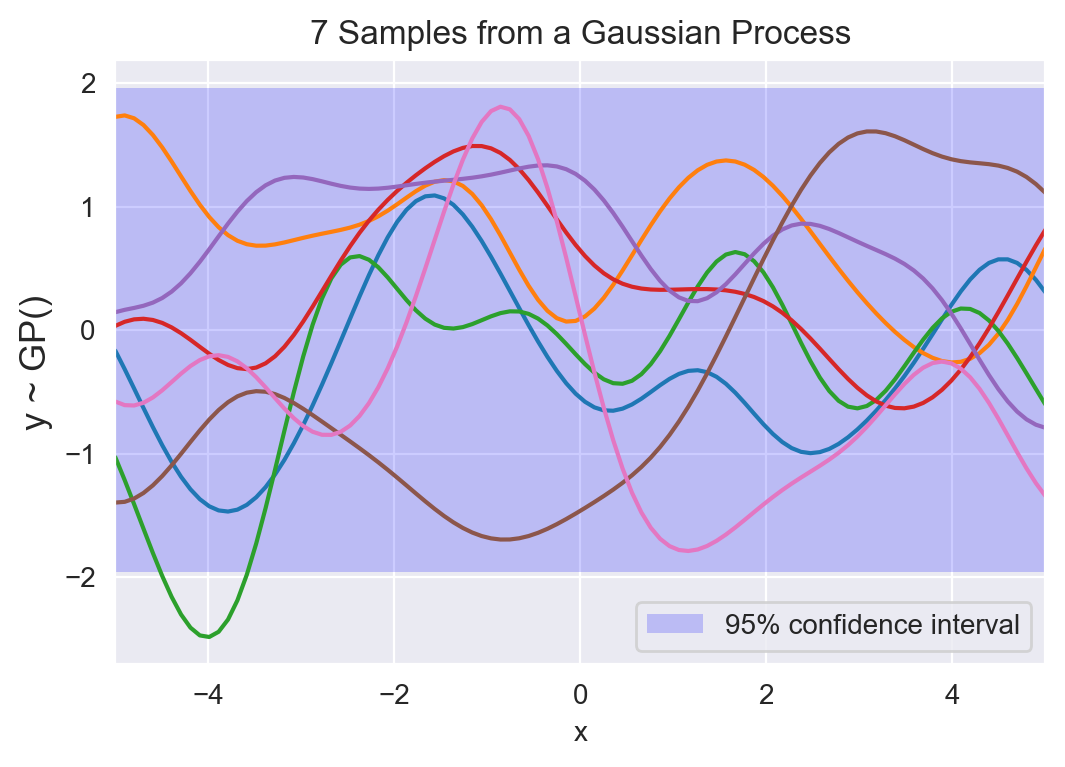

In [3]:
plt.figure(figsize=(6, 4), dpi=100)
sns.color_palette("husl", 8)

_sigma = 1 #kernel([[0]], [[0]])

plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([np.zeros(X.shape[0]) - 1.9600 * _sigma,
                        (np.zeros(X.shape[0]) + 1.9600 * _sigma)[::-1]]),
         alpha=.2, fc='b', ec='None', label='95% confidence interval')
for i in range(n_func):
    plt.plot(X, ys[i], linestyle='-') #, marker='o', markersize=3)
    
plt.xlabel('x')
plt.ylabel('y ~ GP()', fontsize=13)
plt.title('%i Samples from a Gaussian Process' % n_func)
plt.xlim([L, U])
plt.legend()
plt.show();

## Gaussian Process error bars

Interested in what the error bars are. Are they 95% confidence intervals?

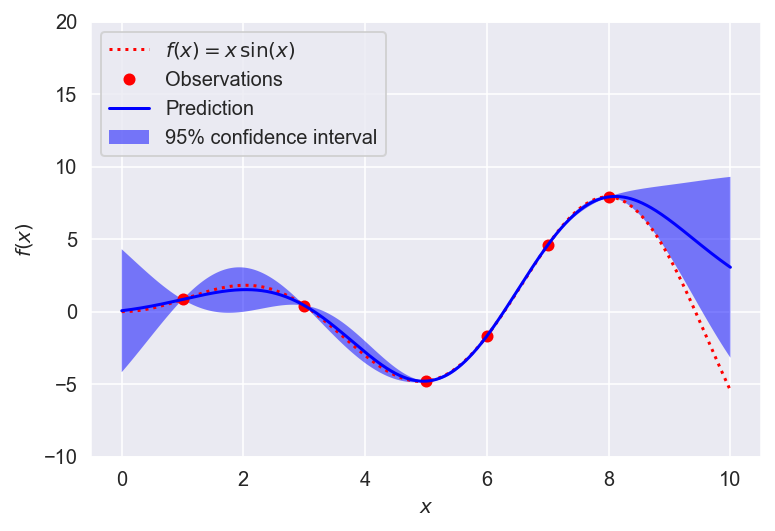

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.linspace(0, 10, 1000).reshape(-1, 1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left');

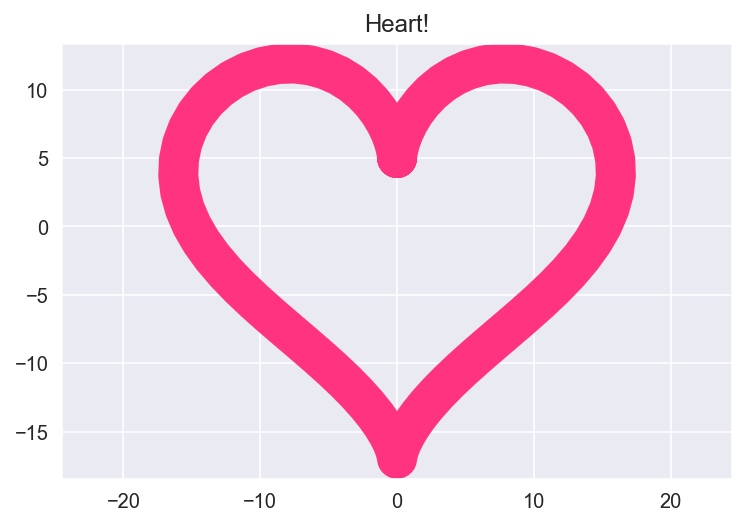

In [5]:
t = np.linspace(0,2*np.pi,100)

x = 16*np.sin(t)**3
y = 13*np.cos(t) - 5*np.cos(2*t) - 2*np.cos(3*t) - np.cos(4*t)

# Plot line with RGB tuple (red=1, green=0.2, blue=0.5)
# and 20pt line width
plt.plot(x,y,c=(1,0.2,0.5),lw=20)

# Add features to our figure
plt.title('Heart!')
plt.axis('equal')
# plt.axis('off')

plt.show();

## GPyTorch GP Regression

https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

### Exact Inference

In [6]:
import math
import torch
import gpytorch
from scipy.stats import norm

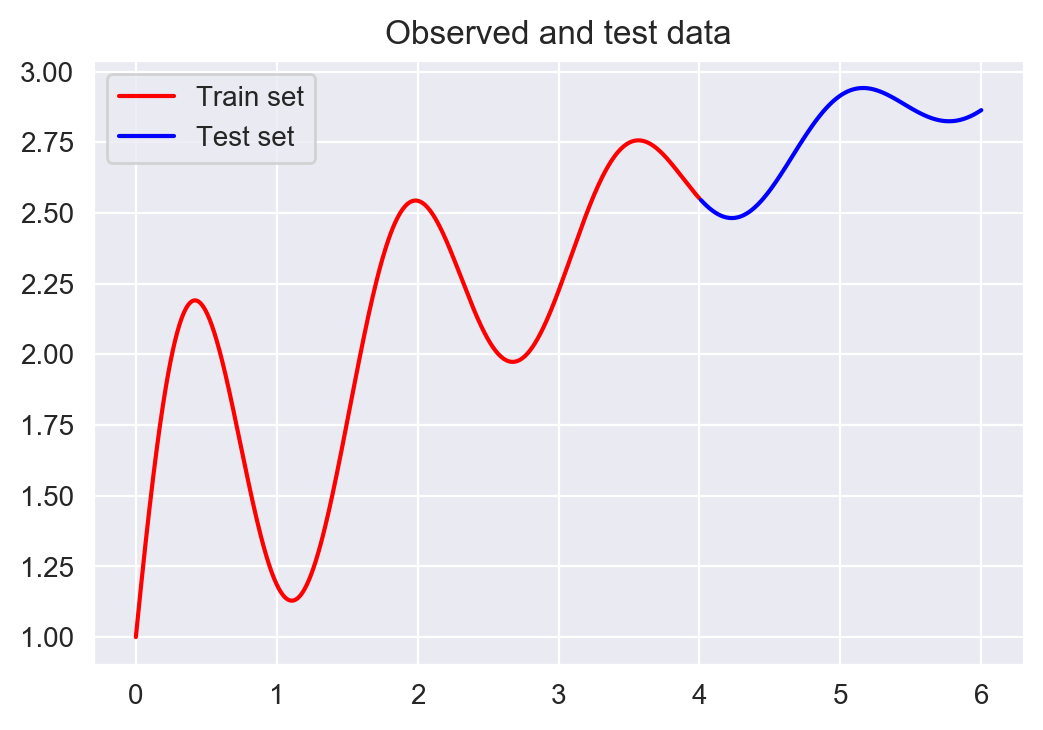

In [135]:
g = np.vectorize(lambda y: math.exp(-0.4 * y)*math.sin(4*y) + math.log(abs(y) + 1) + 1)
train_x = np.linspace(0, 4, 750)
test_x = np.linspace(4.01, 6, 100)
train_x = torch.tensor(train_x)
test_x = torch.tensor(test_x)

train_y = g(train_x) 
test_y = g(test_x) 
train_y=torch.tensor(train_y)
test_y=torch.tensor(test_y)

plt.figure(figsize=(6, 4), dpi=100)
sns.lineplot(train_x, train_y, color = 'red', label = "Train set")
sns.lineplot(test_x, test_y, color = 'blue', label = "Test set")
plt.title("Observed and test data")
plt.legend()
plt.show();

In [126]:
# using GP for exact inference
class ExactGP(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # mean
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # kernel

    def forward(self, x):
        mean_x = self.mean_module(x) 
        covar_x = self.covar_module(x) 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGP(train_x, train_y, likelihood)

In [127]:
training_iter = 50
# Find optimal model hyperparameters
_ = model.train()
_ = likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 10 == 0 :
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/50 - Loss: 0.781   lengthscale: 0.693   noise: 0.693
Iter 11/50 - Loss: 0.374   lengthscale: 0.531   noise: 0.312
Iter 21/50 - Loss: -0.086   lengthscale: 0.616   noise: 0.123
Iter 31/50 - Loss: -0.582   lengthscale: 0.604   noise: 0.045
Iter 41/50 - Loss: -1.094   lengthscale: 0.618   noise: 0.016


In [128]:
_ = model.eval()
_ = likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

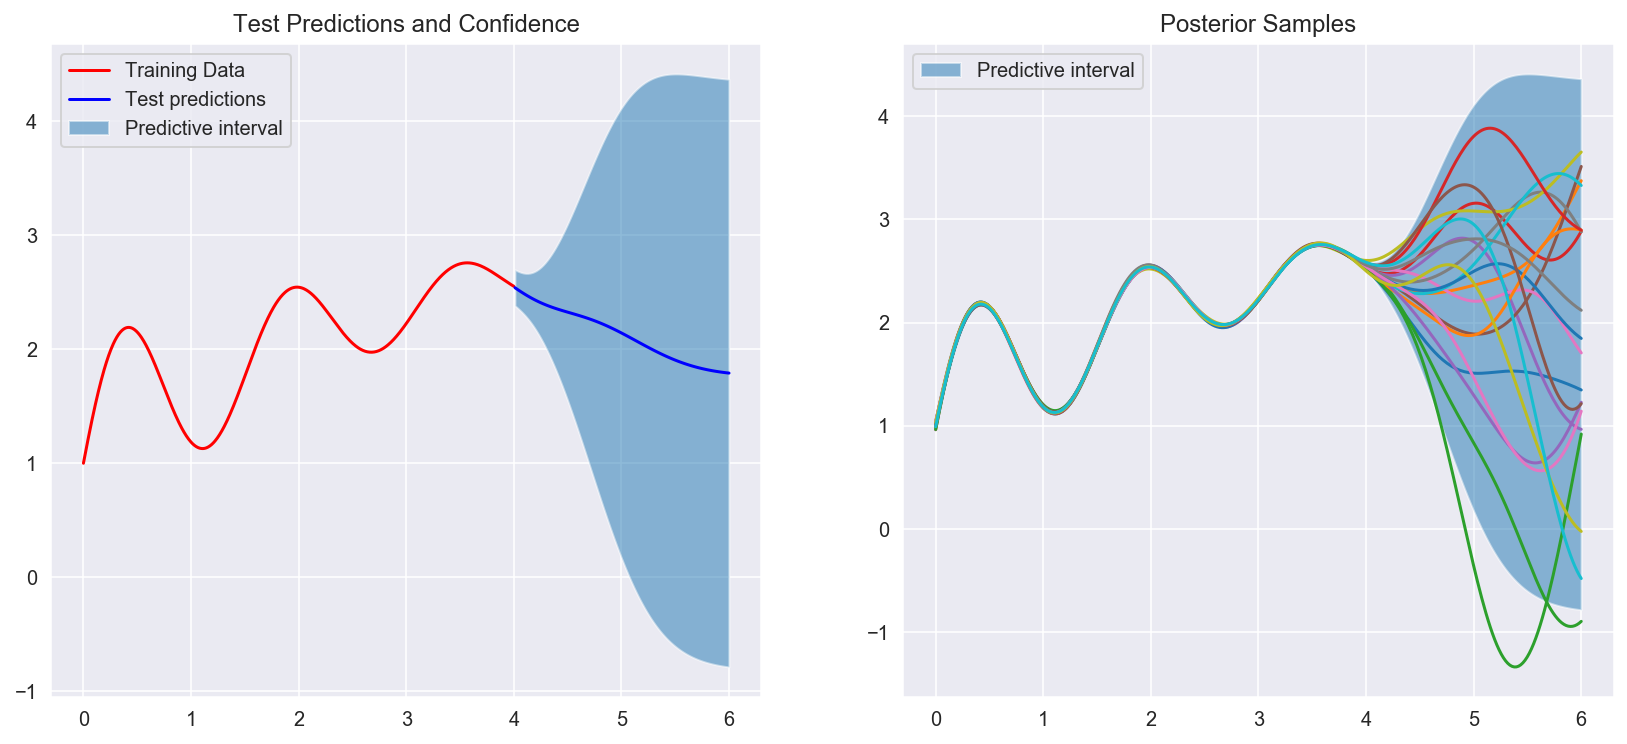

In [129]:
with torch.no_grad():
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    sns.lineplot(train_x.numpy(), train_y.numpy(), color = 'red', ax = ax[0])
    sns.lineplot(test_x.numpy(), observed_pred.mean.numpy(), color = 'blue', ax = ax[0])
    # plot predictive interval
    ax[0].fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
ax[0].legend(['Training Data', 'Test predictions', 'Predictive interval'], loc='upper left')
ax[0].set_title("Test Predictions and Confidence")

all_data = torch.cat((train_x, test_x))
f_preds = model(all_data)
all_lower, all_upper = f_preds.confidence_region()
f_mean = f_preds.mean
f_covar = f_preds.covariance_matrix

n_samples = 20
ys = multivariate_normal.rvs(mean = f_mean.detach().numpy(), 
                             cov = f_covar.detach().numpy(), 
                             size = n_samples)

sns.color_palette("husl", 8)
ax[1].fill_between(all_data.detach().numpy(), all_lower.detach().numpy(), all_upper.detach().numpy(), alpha=0.5,
                label = "Predictive interval")
for i in range(n_samples):
    sns.lineplot(all_data, ys[i], linestyle='-', ax = ax[1])
plt.title("Posterior Samples")
ax[1].legend(loc = 'upper left') #['Training Data', 'Test predictions', 'Predictive interval'], loc='upper left')
plt.show();

In [133]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')
    
raw_outputscale = model.covar_module.raw_outputscale
print('raw_outputscale, ', raw_outputscale)

# Three ways of accessing the raw outputscale constraint
print('\nraw_outputscale_constraint1', model.covar_module.raw_outputscale_constraint)

printmd('\n\n**Printing all model constraints...**\n')
for constraint_name, constraint in model.named_constraints():
    print(f'Constraint name: {constraint_name:55} constraint = {constraint}')

printmd('\n**Getting raw outputscale constraint from model...**')
print(model.constraint_for_parameter_name("covar_module.raw_outputscale"))


printmd('\n**Getting raw outputscale constraint from model.covar_module...**')
print(model.covar_module.constraint_for_parameter_name("raw_outputscale"))

Parameter name: likelihood.noise_covar.raw_noise           value = -5.199735641479492
Parameter name: mean_module.constant                       value = 1.7657138109207153
Parameter name: covar_module.raw_outputscale               value = 1.4439390897750854
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -0.08819524198770523
raw_outputscale,  Parameter containing:
tensor(1.4439, requires_grad=True)

raw_outputscale_constraint1 Positive()




**Printing all model constraints...**


Constraint name: likelihood.noise_covar.raw_noise_constraint             constraint = GreaterThan(1.000E-04)
Constraint name: covar_module.raw_outputscale_constraint                 constraint = Positive()
Constraint name: covar_module.base_kernel.raw_lengthscale_constraint     constraint = Positive()



**Getting raw outputscale constraint from model...**

Positive()



**Getting raw outputscale constraint from model.covar_module...**

Positive()
